# Project File - APS360 Team 25
Divided into the following section: 
# 
1) Library imports
2) Data imports
3) Model architecture definition
4) Training function definition
5) Model training
6) Model testing

## Library imports 
(Place all library imports here)

In [3]:
#KP - I just added the main ones from the labs.
import torch
import numpy as np

#import torchvision
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

import torch.nn.functional as F
import torch.optim as optim

import time # Tracking model training time.

#for Data importing
import mido
from mido import MidiFile, Message, MidiTrack, MetaMessage
import os
import random

## Data imports
#### MIDI reading functions

In [4]:
def CountTracks(directory):          #Count files and tracks in folder
    trackCount = 0
    fileCount = 0
    for file in os.listdir(directory):
        if file.endswith(".midi"):
            fileCount += 1
            midiDir = MidiFile(directory+"/"+file)
            for track in midiDir.tracks:
                trackCount += 1
    print(fileCount+" files")
    print(trackCount+" tracks")

    
def PrintMessages(mid):                # print midi messages
    for i, track in enumerate(mid.tracks):
        print('Track {}: {}'.format(i, track.name))
        for msg in track:
            print(msg)

            
def PrintSomeMessages(mid):             #print first 200 midi messages
    track = mid.tracks[1]
    for i,msg in enumerate(track):
        if i < 200:
            print(msg)
            
def PrintMetaMessages(mid):             #print fmeta messages
    track = mid.tracks[0]
    for i,msg in enumerate(track):
        print(msg)

def cleanupMessages(mid):              #removes non-note messages by force
    track = mid.tracks[1]
    track2 = []
    for msg in track:
        if msg.type == "note_on":
            track2.append(msg)
    mid.tracks[1] = track2

#### MIDI to Numpy code

In [5]:
def Midi2NumpyNoSustain(mid):                                #converts to numpy array removing non-note messages
    track = mid.tracks[1]                           #0th track only contains meta-messages, all notes on 1st track
    notes = np.empty([0,4])
    time = 0
    for msg in track:
        if msg.type == "note_on":                   # only count "note" messages - other inputs i.e. foot pedals are ignored
            notes = np.append(notes,np.array([[msg.note, msg.velocity, msg.time + time, 0]]),axis=0)         # (note, velocity, time, sustain)
            time = 0
        else:
            time += msg.time                        #adjust time when removing other messages
    return notes


def NumpyGetSustain(note):
    notes = np.copy(note)
    for i, msg in enumerate(notes):
        if msg[1] > 0:                            # if velocity is not 0
            j = 1
            sustain = 0
            while msg[0] != notes[i+j][0]:        # while note values are different
                sustain += notes[i+j][2]
                j += 1                            #search for next message with same note i.e. message telling that note was released
            notes[i,3] = sustain + notes[i+j][2]
    time = 0
    for i, msg in enumerate(notes):
        if msg[1] > 0:
            notes[i,2] += time
            time = 0
        else:
            time += msg[2]                        #adjust time
    notes = notes[notes[:,1] > 0]                 #filter for notes with positive velocities (note presses)
    return notes

def NumpyNormalize(note, oneHot=False):                         #normalize all values to 0-1
    notes = np.copy(note)
    
    if oneHot:
        notes[:,12] /= 11
        notes[:,13] /= 128
        notes[:,14] /= 40000
        notes[:,15] /= 40000
    else:
        notes[:,0] /= 128
        notes[:,1] /= 128
        notes[:,2] /= 40000
        notes[:,3] /= 40000       
    return notes

def NumpyOneHot(note):
    notes = np.copy(note)
    oneHot = np.zeros([len(notes),16])
    oneHot[:, 13:] = notes[:, 1:]
    names = notes[:,0]
    namesOct = names%12
    oneHot[:,12] = (names-(namesOct))/12
    
    for i, name in enumerate(namesOct):
        oneHot[i,name.astype(int)] = 1
    
    return oneHot

def Midi2Numpy(path, oneHot=False): # full midi to numpy conversion
    mid = MidiFile(path)
    notes = Midi2NumpyNoSustain(mid)
    cleanNotes = NumpyGetSustain(notes)
    
    if oneHot:
        cleanNotes = NumpyOneHot(cleanNotes)
    
    normNotes = NumpyNormalize(cleanNotes, oneHot=oneHot)
    return normNotes

#### Numpy to MIDI code

In [6]:
def NumpyDenormalize(note): # interpret all values from 0-1 to normal values
    notes = np.copy(note)    
    if notes.shape[1] == 16: # if encode as one-hot
        notes[:,12] *= 11
        notes[:,13] *= 128
        notes[:,14] *= 40000
        notes[:,15] *= 40000
        
        notes = NumpyEncode(notes) #encode back as original 4-variable format
    else:
        notes[:,0] *= 128
        notes[:,1] *= 128
        notes[:,2] *= 40000
        notes[:,3] *= 40000       
    return notes.astype(int)

def NumpyEncode(note): # convert back from one-hot encoding
    notes = np.copy(note)
    encoded = np.zeros([len(notes),4])
    encoded[:, 1:] = notes[:, 13:]
    encoded[:, 0] = notes[:,12]*12
    
    for i in range(len(notes)):
        encoded[i,0] += np.argmax(notes[i,:12])
    
    return encoded

def NumpySequence(notes): # put all notes into a "timeline" i.e.: time values of [10, 20, 10, 30] become [10, 30, 40, 70]
    sequenced = np.copy(notes)                      # this allows us to easily add vel=0 notes in any order since we can later sort them by time
    for i, msg in enumerate(sequenced):
        if i > 0:
            sequenced[i,2] += sequenced[i-1,2]
    return sequenced

def NumpyAddOffNotes(sequenced): # add vel=0 notes from sustain into sequenced timeline
    withOff = np.copy(sequenced)
    for msg in sequenced:
        offNote = np.array([[msg[0], 0, msg[2] + msg[3], 0]])
        withOff = np.append(withOff, offNote, axis=0)
    #withOff = np.sort(withOff,axis=0)
    withOff = withOff[withOff[:,2].argsort()] # sort by time
    return withOff

def NumpyUnsequence(notes): # revert time value to "time since last message"
    unsequenced = np.copy(notes)
    for i, msg in reversed(list(enumerate(unsequenced))):
        unsequenced[i,3] = 0
        if i > 0:
            unsequenced[i,2] -= unsequenced[i-1,2]
    return unsequenced

def Numpy2MidiDirect(array):    #make MIDI object from numpy
    #Start with initializing a new Mido Track:
    mid = MidiFile()
    track0 = MidiTrack()
    track1 = MidiTrack()
    
    track0.append(MetaMessage('set_tempo', tempo=500000, time=0)) #MetaMessages not necessary but are present in used files
    track0.append(MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
    track0.append(MetaMessage('end_of_track', time=1))
    
    track1.append(Message('program_change', channel=0, program=0, time=0))
    
    for i,note in enumerate(array):         # Get the index and the note. Array must be int array
        j = 1
        track1.append(Message('note_on',note = array[i,0], velocity = array[i,1],time = array[i,2])) # Add the note to the track.

    mid.tracks.append(track0)
    mid.tracks.append(track1)
    return mid

def Numpy2Midi(notes, name): # full numpy to midi conversion, saving result to [name].midi
    denorm = NumpyDenormalize(notes)
    seq = NumpySequence(denorm)
    off = NumpyAddOffNotes(seq)
    unseq = NumpyUnsequence(off)
    mid = Numpy2MidiDirect(unseq)
    mid.save(name + ".midi")

#### Generatng tensor dataset from CSVs

In [7]:
def Numpy2Dataset(notes,num=21,skip=21): # make list of sumpy arrays
    samples = []
    targets = []
    i = 0
    while i+num <= len(notes):
        samples.append(notes[i:i+num-1])
        targets.append(notes[i+num-1])
        i += skip
    return samples, targets

def SampleAllNumpy(dataPath): # generate samples from all saved CSVs
    allSamples = []
    allTargets = []

    for i,f in enumerate(os.listdir(dataPath)):
        notes = np.genfromtxt(dataPath+f, delimiter=',')
        samples, targets = Numpy2Dataset(notes)
        allSamples += samples
        allTargets += targets
        if i % 100 == 0:
            print(i)
            
    random.seed(0)
    random.shuffle(allSamples)
    random.seed(0)
    random.shuffle(allTargets)
    
    return allSamples, allTargets

def SaveSamplesTensor(samples, targets, outputPath, name="Notes_Dataset"): # save tensor
    tens = torch.Tensor(samples)
    targ = torch.Tensor(targets)
    dataset = TensorDataset(tens,targ)
    torch.save(dataset, outputPath+name+".pt")
    return tens   

def SaveAllSamples(dataPath, outputPath, name="Notes_Dataset"): # save dataset tensor
    samples, targets = SampleAllNumpy(dataPath)
    SaveSamplesTensor(samples, targets, outputPath, name)
    
def SplitSamples(dataset, ranges):
    torch.maual_seed(0)
    trainData, valData, testData = random_split(oneHotDataset, splitRange)
    return trainData, valData, testData 

#### Bulk data conversion code - COMMENT OUT IF NOT IN USE!!!

In [8]:
# #SaveAllSamples("data/numpy_onehot/","data/onehot_data/","onehot") #save all into tensor

# oneHotDataset = torch.load("data/onehot_data/onehot.pt")

# splitProp = np.array([0.9, 0.05 , 0.05]) # 90/5/5% split
# splitRange = len(oneHotDataset)*splitProp
# splitRange[0] += 1                           # so numbers add up
# splitRange = splitRange.astype(int)

# length = len(oneHotDataset)
# a = 0.9*length
# a = int(a)

# b = 0.95*length
# b = int(b)

# tiny = oneHotDataset[:30]
# train = oneHotDataset[:a]
# val = oneHotDataset[a:b]
# test = oneHotDataset[b:]

# tinyData = TensorDataset(tiny[0].clone(), tiny[1].clone())
# trainData = TensorDataset(train[0].clone(),train[1].clone())
# valData = TensorDataset(val[0].clone(),val[1].clone())
# testData = TensorDataset(test[0].clone(),test[1].clone())

# torch.save(tinyData,"data/onehot_data/tinyDataOneHot.pt")
# torch.save(trainData,"data/onehot_data/trainDataOneHot.pt")
# torch.save(valData,"data/onehot_data/valDataOneHot.pt")
# torch.save(testData,"data/onehot_data/testDataOneHot.pt")

In [9]:
# IMPORTANT: COMMENT OUT IF NOT IN USE TO AVOID ACCIDENTS!!!!!!!

# Getting CSVs from MIDI data and processed data from CSVs
# Processed MIDI does not contain program messages and so are a good measure of what output SHOULD look like in a perfect world

# dataPath = "data/MIDI_files_original/"
# outputPath = "data/numpy_files/"
# processedPath = "data/MIDI_files_processed/"

# for i,f in enumerate(os.listdir(dataPath)):
#     notes = Midi2Numpy(dataPath+f)
#     np.savetxt(outputPath + "MIDI_{:04d}.csv".format(i),notes,delimiter=",")
#     Numpy2Midi(notes, processedPath + "MIDI_{:04d}".format(i))
    
#     if i % 100 == 0:
#         print(i)

In [10]:
# dataPath = "data/numpy_files/"  # one-hot encoding on CSVs
# outputPath = "data/numpy_onehot"

# for i,f in enumerate(os.listdir(dataPath)):
#     notes = np.genfromtxt(dataPath+f, delimiter=',')
#     notes = NumpyDenormalize(notes)
#     notes = NumpyOneHot(notes)
#     notes = NumpyNormalize(notes, oneHot=True)
#     np.savetxt(outputPath + "MIDI_{:04d}.csv".format(i),notes,delimiter=",")
#     if i % 100 == 0:
#         print(i)

## Baseline Model Code
#### getting available notes

In [11]:
def GetAllNotesMajor(root):# Get all used notes in major scale of root=root
    notes = []
    intervals = [2,2,1,2,2,2,1]
    
    while root > 24: #bring down to lowest used octave
        root -= 12
    
    n = root
    notes.append(n)
    while n < 84: #up to higherst used note
        for i in intervals:
            n += i
            notes.append(n)   
    return notes    


def GetRangeMajor(notes, low, high): # Get all notes within range
    lowIndex = notes.index(low)
    highIndex = notes.index(high)
    
    return notes[lowIndex:highIndex+1]   

#### Piece Class
##### represents whole output from all 4 voices

In [12]:
class Piece: # Entire baseline model compostion - composed of 4 voices soprano, alto, tenor, bass (SATB)
    def __init__(self, barNum=16, root=60):# 16 bars in C major
        self.root = root # root note
        self.allNotes = GetAllNotesMajor(self.root) # all notes on major scale
        self.barNum = barNum # number of bars
        
        self.soprano = Voice(self.allNotes,60,84,speed=8) # SATB
        self.alto = Voice(self.allNotes,48,72)
        self.tenor = Voice(self.allNotes,36,60)
        self.bass = Voice(self.allNotes,24,48)
          
        self.notes = np.empty([0,4]) #notes output
        
        self.pieceChords = [] # chords
        
        self.chords = np.array([ # common classical C major chords
            [ 0,  4,  7,  0],# I
            [ 2,  5,  9,  2],# ii
            [ 4,  7, 11,  4],# iii
            [ 5,  9, 0,  5],# IV
            [ 7, 11, 2,  7],# V
            [ 9, 0, 4,  9],# vi
            [11, 2, 5, 11],# vii dim
            [ 2,  5,  9, 0],# ii7
            [ 5,  9, 0, 4],# IVmaj7
            [ 7, 11, 2, 5],# V7
            [11, 2, 5, 9]])# vii7 half-dim
        
    def GenerateSoprano(self): # Generate soprano line
        self.soprano.GenerateLine(self.soprano.speed*self.barNum)
        
    def GenerateAlto(self): # Generate alto line from chords
        self.alto.GenerateChordLine(self.pieceChords)
        
    def GenerateTenor(self): # see alto
        self.tenor.GenerateChordLine(self.pieceChords)
        
    def GenerateBass(self): # see alto
        self.bass.GenerateChordLine(self.pieceChords)
        
        
    
    def ChooseChord(self, sopNote): # Choose a fitting chord for soprano note
        while sopNote >= 12:
            sopNote -= 12
        
        goodChords = np.empty([0,4])
        
        for chord in self.chords:
            if (chord==sopNote).sum() > 0:
                goodChords = np.append(goodChords,[chord],axis=0)
        
        chosenChord = goodChords[random.randint(0,len(goodChords)-1)]
        chosenChord = np.sort(np.unique(chosenChord))
        
        i = 12
        chordNotes = chosenChord
        while i < 120:
            chordNotes = np.append(chordNotes, chosenChord+i)
            i += 12
        
        return(chordNotes)
    
    def GetChords(self): # select all chords in piece
        for i, note in enumerate(self.soprano.notes):
            if i % 2 == 0:
                sopNote = note[0]
                chord = self.ChooseChord(sopNote)
                self.pieceChords.append(chord)
                
    def Normalize(self): # normalize all values to 0-1
        for i, msg in enumerate(self.notes):
            self.notes[i,0] = msg[0]/128
            self.notes[i,1] = msg[1]/128
            self.notes[i,2] = msg[2]/40000
            self.notes[i,3] = msg[3]/40000
                
    def GenerateLines(self): # Generate all SATB lines and joins them - entire baseline model
        self.GenerateSoprano()
        self.GetChords()
        self.GenerateAlto()
        self.GenerateTenor()
        self.GenerateBass()
        self.joinLines()
        self.OffsetTime(20)
        self.Normalize()
        
        return self.notes
        
    def InsertLine(self, starting, inserted, startIndex, skipIndex): # join 2 lines
        base = np.copy(starting)
        ins = np.copy(inserted)
        
        for i,note in enumerate(ins):
            base = np.insert(base, (i*skipIndex)+startIndex, [note], axis=0)
            
        return base
        
    def joinLines(self): # join all SATB lines
        #self.notes = np.copy(self.soprano)
        self.notes = self.InsertLine(self.soprano.notes, self.alto.notes, 1, 3)
        self.notes = self.InsertLine(self.notes, self.tenor.notes, 2, 4)
        self.notes = self.InsertLine(self.notes, self.bass.notes, 3, 5)
        
    def OffsetTime(self, maxChange): # adds random time offsets to make output sound more organic
        for note in self.notes:
            note[2] += random.randint(0,maxChange)
        

#### Voice class
##### Represents individual voices

In [13]:
class Voice: # individual voices
    def __init__(self, allNotes, lowNote, highNote, jump=3, speed=4, time=4096, velocity=64):
        self.range = GetRangeMajor(allNotes,lowNote,highNote) #available ntoes
        self.jump = jump #maximum pitch interval between notes
        self.speed = speed #note length i.e. 4 for quarter, 8 for eighth etc.
        self.time = time #song speed
        self.velocity = velocity #note volume
        self.notes = np.empty([0,4]) #notes output
        self.lowNote = lowNote # lowest note
        self.highNote = highNote # highest note
        self.allNotes = allNotes # all notes in scale
            
        self.duration = self.time / self.speed # time between notes
        
        
    def RandomStartNote(self): # Generate Random first note (for soprano)
        note = random.choice(self.range)
        self.notes = np.append(self.notes,np.array([[note, self.velocity, 0, self.duration]]),axis=0)
        
        
    def RandomJump(self): # Generate Random next note (for soprano)
        lastNote = self.notes[len(self.notes)-1][0] # find last played note
        lastIndex = self.range.index(lastNote)
        
        newIndex = -1
        while newIndex < 0 or newIndex >= len(self.range): # stay in range
            newIndex = lastIndex + random.randint(-self.jump,self.jump)
            
        newNote = self.range[newIndex]
        self.notes = np.append(self.notes,np.array([[newNote, self.velocity, self.duration, self.duration]]),axis=0)
        
        
    def GenerateLine(self, length): # Generate random line (for soprano)
        self.RandomStartNote()
        
        for n in range(length-1):
            self.RandomJump()
            
            
    def clearNotes(self):
        self.notes = np.empty([0,4])
        
    def GetChordNotes(self, chordNotes): # Get useful notes from all chord notes
        chordNotes = chordNotes[chordNotes >= self.lowNote]
        chordNotes = chordNotes[chordNotes <= self.highNote]
        return chordNotes
    
    def ChooseStartChordNote(self, chordNotes): # Choose Random note in chord
        note = random.choice(chordNotes)
        self.notes = np.append(self.notes,np.array([[note, self.velocity, 0, self.duration]]),axis=0)
        
    def ChooseChordNote(self,chordNotes): # Choose suitable next note in chord
        lastNote = self.notes[len(self.notes)-1][0] # find last played note
        
        chordNotes = chordNotes[chordNotes >= lastNote - (self.jump*2)]
        chordNotes = chordNotes[chordNotes <= lastNote + (self.jump*2)]
        newNote = random.choice(chordNotes)
        
        self.notes = np.append(self.notes,np.array([[newNote, self.velocity, 0, self.duration]]),axis=0)
        
    def GenerateChordLine(self, chords): # Generate A/T/B lines
        
        firstChord = self.GetChordNotes(chords[0])
        self.ChooseStartChordNote(firstChord)
        
        for c in chords[1:]:
            chord = self.GetChordNotes(c)
            self.ChooseChordNote(chord)

In [20]:
def get_accuracy(model, train=False):
    if train:
        data = trainData
    else:
        data = valData
        
    err = 0
    total = 0
for imgs, labels in torch.utils.data.DataLoader(data, batch_size=overfitBatch):
        imgs = imgs.cuda()
        labels = labels.cuda()
          
        output = model(imgs)
        #select index with maximum prediction score
        lab = labels.view_as(output)
        
        error = abs(output-lab).sum().item()
        
        err += error/16
        total += imgs.shape[0]
    totalError = err / total
    return totalError

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 21)

In [21]:
def train(model, batch_size=256, learning_rate=0.001, num_epochs=1, model_name="model"):
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Cross-Entropy Loss and SGD are commonly used for classification problems

    iters, losses, train_err, val_err = [], [], [], []
    
    maxVal = 0
    
    if torch.cuda.is_available():
        print("using cuda")

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(trainLoader):
            
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy
            valAccuracy = get_accuracy(model, train=False)
            val_acc.append(valAccuracy)  # compute validation accuracy
            
            if valAccuracy > maxVal and valAccuracy > 0.6:
                maxVal = valAccuracy
                torch.save(model.state_dict(), model_name)
                print("Validation record in iteration {}: {}".format(n, maxVal)) # save model when validation accuracy is higher than previous runs
            
            n += 1
            if n % 100 == 0:
                print(n)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    return maxModel

## Model architecture definition

Set the hyperparameters below:


In [183]:
torch.manual_seed(1)
class MusicGenerator(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super(MusicGenerator, self).__init__()
        self.name = "SergModel"
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.rnn = nn.LSTM(self.input_size, self.hidden_size, batch_first = True)
        #^^Expects data as: (batch_size,sequence,features)
        self.fc1 = nn.Linear(self.hidden_size, 32)
        self.fc2 = nn.Linear(32,16)
        self.sig = nn.Sigmoid()
        #self.linear = nn.Linear(self.hidden_size, 4) #Regression problem.

    def forward(self, x):
        h0 = torch.zeros(1,x.size(0),self.hidden_size)
        h0 = h0.cuda()
        c0 = torch.zeros(1,x.size(0),self.hidden_size)
        c0 = c0.cuda()
        out,(h0,c0) = self.rnn(x,(h0,c0))
        x = F.relu(out)
        x = F.relu(self.fc1(x)) # 2 fully connected layers
        x = self.fc2(x)
        x = self.sig(x)
        pred = x[:,-1,:]
        
        return pred
    
print('Model class created succesfully')

Model class created succesfully


#### Scuffed training code

In [184]:
valData = torch.load("data/onehot_data/valDataOneHot.pt")
overfitData = valData
overfitData = list(overfitData)

#print(len(overfitData))
overfitBatch = 512

In [185]:

#overfitLoader = torch.utils.data.DataLoader(overfitData, batch_size=overfitBatch, shuffle=False)

def OverfitAccuracy(model): # NOT USED - SAME AS ERROR
    data = overfitData

    err = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=overfitBatch):
        imgs = imgs.cuda()
        labels = labels.cuda()
          
        output = model(imgs)
        #select index with maximum prediction score
        lab = labels.view_as(output)
        
        error = abs(output-lab).sum().item()
        
        err += error/16
        total += imgs.shape[0]
    totalError = err / total
    return totalError

In [186]:
# tinyData = torch.load("data/onehot_data/tinyDataOneHot.pt")
# overfitData = tinyData
# overfitData = list(overfitData)
# overfitBatch

In [191]:
def OverfitTrain(model, data, batch_size=overfitBatch, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=overfitBatch)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    iters, losses, train_acc, val_acc = [], [], [], []
    
    if torch.cuda.is_available():
        print("using cuda")

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            #print(float(loss)/batch_size)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(OverfitAccuracy2(model)) # compute training accuracy 
            n += 1
            if n % 50 == 0:
                print(n)
            

    # plotting
    plt.title("Overfit Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Note Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    

In [192]:
def OverfitAccuracy2(model):
    data = overfitData

    #err = 0
    total = 0
    correct = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=overfitBatch):
        imgs = imgs.cuda()
        labels = labels.cuda()
          
        output = model(imgs)[:,:12]
        pred = output==output.max(1, keepdim=True)[0]
        pred = pred.float()
        
        #select index with maximum prediction score
        lab = labels[:,:12].view_as(output)
        
        correct += pred.eq(lab).sum().item()
        
        #error = abs(output-lab).sum().item()
        
        #err += error/16
        total += imgs.shape[0]*12
    #totalError = err / total
    accuracy = correct/total
    
    return accuracy

In [193]:
OverfitAccuracy2(overfitModel)

0.8484580110605972

using cuda
50
100
150
200
250
300


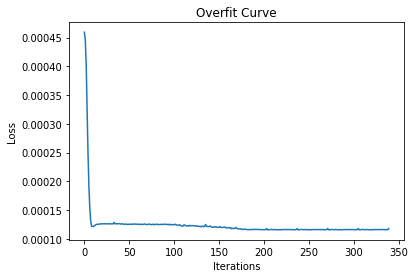

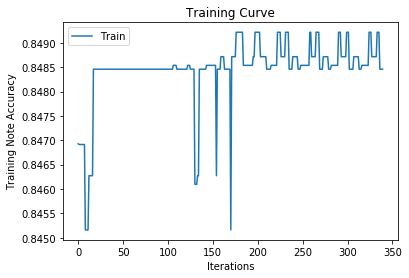

Final Training Accuracy: 0.8484580110605972


In [194]:
torch.manual_seed(2)
overfitModel = MusicGenerator()
overfitModel = overfitModel.cuda()
OverfitTrain(overfitModel, overfitData, num_epochs=10)

In [53]:
loader = torch.utils.data.DataLoader(tinyData, batch_size=1)

In [195]:
iii = 0
for a, b in iter(loader): 
    if iii < 3:
        a = a.cuda()
        print(overfitModel(a))
        print(b)
        print()
    iii += 1

tensor([[0.0870, 0.0707, 0.0921, 0.0871, 0.0808, 0.0967, 0.0749, 0.0829, 0.0784,
         0.0976, 0.0735, 0.0750, 0.4283, 0.4943, 0.0069, 0.0074]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.5455e-01, 4.0625e-01, 1.0000e-04, 1.0000e-03]])

tensor([[0.0870, 0.0707, 0.0921, 0.0871, 0.0808, 0.0967, 0.0749, 0.0829, 0.0784,
         0.0976, 0.0735, 0.0750, 0.4283, 0.4943, 0.0069, 0.0074]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.6364e-01, 4.9219e-01, 9.2500e-04, 2.1750e-03]])

tensor([[0.0869, 0.0707, 0.0921, 0.0871, 0.0808, 0.0967, 0.0749, 0.0829, 0.0784,
         0.0976, 0.0735, 0.0750, 0.4284, 0.4943, 0.0069, 0.0074]],
       device=

In [ ]:
overfitModel(tinyData[0])

In [ ]:
class RNNMusicGenerator(nn.Module): #GRU based
    def __init__(self, input_size = 16, hidden_size = 64):
        super(RNNMusicGenerator, self).__init__()
        self.name = "LSTM_Reg_ws20_simple_model"
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.rnn = nn.LSTM(self.input_size, self.hidden_size, batch_first = True)
#         self.rnn1 = nn.LSTM(self.hidden_size, self.hidden_size, batch_first = True)
        self.rnn1 = nn.LSTM(self.hidden_size, self.hidden_size, batch_first = True)
        #^^Expects data as: (batch_size,sequence,features)
        self.linear1 = nn.Linear(self.hidden_size, 32)
        self.linear2 = nn.Linear(32,16)
        self.linear = nn.Linear(self.hidden_size, 4) #Regression problem.

    def forward(self, x):
        h0 = torch.zeros(1,x.size(0),self.hidden_size)
        c0 = torch.zeros(1,x.size(0),self.hidden_size)
        out,(h0,c0) = self.rnn(x,(h0,c0))
        out = F.relu(out)
#         h1 = torch.zeros(1,x.size(0),self.input_size)
#         c1 = torch.zeros(1,x.size(0),self.input_size)
#         out,(h0,c0) = self.rnn1(out,(h0,c0))
#         out = F.relu(out)
#         out,(h0,c0) = self.rnn1(out,(h0,c0))
#         print(output.shape)
#         out = F.relu(out)
#         output,_ = self.RNN2(output,(None,None)) #No activation function on second layer for now...
#         print(hidden)    
#         out = self.linear1(out[:,-1,:])
#         out = self.linear(out) #Takes the last one...
#         out = F.relu(out)
#         out = self.linear2(out)
#         out = F.relu(out)
        pred = self.linear(out[:,-1,:]) #Takes the last one...
        return pred, True
    
print('Model class created succesfully')

In [ ]:
#For LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM 
n1 = 1 #Number of input features
nh1 = 1 #Number of features in the hidden state h
nl1 = 1 #Number of layers in each LSTM calling (more than 1 stacks them with same number of hidden features).
dropout1 = 0 #Percentage dropout of each layer. I believe 0-->1 range.

n2 = 1 #Number of input features
nh2 = 1 #Number of features in the hidden state h
nl2 = 1 #Number of layers in each LSTM calling (more than 1 stacks them with same number of hidden features).
dropout2 = 0 #Percentage dropout of each layer. I believe 0-->1 range.

In [ ]:
torch.manual_seed(1000) #Set the manual seed so that we get reproducible results.

#Define the RNNMusicGenerator model below:
class RNNMusicGenerator(nn.Module): 
    def __init__(self):
        super(RNNMusicGenerator, self).__init__()
        self.name = "MusicGen"
        self.LSTM1 = nn.LSTM(input_size = n1, hidden_size = nh1,num_layers = nl1, batch_first = True,dropout = dropout1)
        #^^Expects data as: (batch_size,sequence,features)
        self.LSTM2 = nn.LSTM(input_size = n, hidden_size = nh,num_layers = nl, batch_first = True,dropout = dropout)
        #unsure of the output dimensions still...
    def forward(self, x):
        x = (F.relu(self.LSTM1(x)))
        x = self.LSTM2(x) #No activation function on second layer for now...
        return x
    
print('Model class created succesfully')

## Training function

In [ ]:
#To help us save the model easier...
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


In [ ]:
def train(model,data, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(1000) #Fixed. Make sure we use this throughout...
    criterion = nn.MSELoss() # mean square error loss. Compares reconstruction errors entry by entry.
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <-- Sometimes Adam converges faster than SGD
    train_loader = torch.utils.data.DataLoader(data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    
    iters, losses = [], []
    
    n = 0 # the number of iterations
    start_time=time.time() #Start of training.
    outputs = []
    
    for epoch in range(num_epochs):
        for data in train_loader:
            excerpt = data[:-1] # Extracts all but the last note (model will predict last note)
            true_note = data[-1] # Extracts the last note.
            pred_note = model(excerpt) # Collects next note prediction.
            loss = criterion(pred_note, true_note)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # Clean up, clean up, everybody, everywhere...

                
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            
            n += 1
        
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, true_note, pred_note),)
      #Checkpoint the model every epoch
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch) #Returns the model name for 
      #the save file.
        print('model_path: ',model_path)
        torch.save(model.state_dict(), model_path) #Saves the current model with the weights.
        print('model checkpointed')
    end_time= time.time()
    
    
      # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    return outputs

## Model Training

In [ ]:
model = RNNMusicGenerator()

train(model,data,batch_size = 1,num_epochs = 1,lr = 0.0001)

## Model Testing

Since our model is 'tested' with people listening to it, we need to just generate some samples.

In [ ]:
#Using random noise inputs:

x = torch.randn(1, 1, 1) # (Batch_size,sequence,notes) --> Must match the LSTM layer input.

song_length = 1 #How many new notes we want the model to generate.

start = True
for t in range(0,song_length): #Generates t new notes.
    new_sample = model(x)
    if start:
        new_excerpt = torch.cat(x,new_sample) #initializes new_excerpt as the random noise + new note
    else:
        new_excerpt = torch.cat(new_excerpt,new_sample)
    x = torch.cat(x[1:],new_sample) #Update x by throwing out the first note in the sequence and shoving the new note to the end.

print('loop done')